# SLIM Tricks -- Simulation Generation Outline

## Generate a simple Monomer, Extruded Polymer, and Standard Turn

In [1]:
from PIL import Image, ImageDraw # pixel-accurate images, see pillow.readthedocs.io

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl

## Dictionary of Model Parameters --> Parameter lua

### This workflow relies on integrating our python tools for designing planar ion guides with a lua-based initliaization script that SIMION can read. Starting with a dictionary of global variables and saving that to a parameter file that the setup lua can access is a good first step. Some parameters are just for drawing, some are required for the ion bench to initilaize correctly.

In [2]:
def writeParamFile(paramDict, fileName):
    '''write some variables to carry over to setup lua'''
    f = open(fileName, 'w')
    for k in paramDict.keys():
        l = '%s = %s    %s\n'%(k, paramDict[k][0], paramDict[k][1])
        f.write(l)
#         print(k, '=', paramDict[k][0], paramDict[k][1])
    f.close()
    
    print("%s written to file"%fileName,"\n")
    
def dict_to_table(dictionary):
    '''standard conversion - lua  uses tables instead of dicts'''
    table_string = '{'
    for key, val in zip(dictionary.keys(), dictionary.values()):
#         print(key)
        entry ='["%s"]'%key + ' = %s'%val+', '
        table_string += entry
    
    table_string = table_string[:-2]
    table_string +='}'
    
    return(table_string)

## This version has been modified to output symmetric or asymmetric SLIM board pairs. Change the paramDict "symmetry" to "'ASY'" to generate two distinct boards.

In [3]:
paramDict = {}

# by convenience, measure models in pixels
pixelScale = 0.0254 # 1 pixel is 0.001" which is 0.0254 mm

# symmetry of electrodes:
symmetry = "'SYM'"
# symmetry = "'ASY'"
paramDict['Symmetry'] = [symmetry, '--Field Symmetry']

## SLIM electrode dimensions:
wElectrode = 16 # value in pixels and in this case 0.001" or 1 mil
paramDict['wElectrode'] = [wElectrode*pixelScale, '--Width of the DC electrode (mm)']

lElectrode = 40 
paramDict['lElectrode'] = [lElectrode*pixelScale, '--Length of the DC electrode (mm)']

wRF = 16
paramDict['wRF'] = [wRF*pixelScale, '--Width of the RF (mm)'] 

wGuard = 124 
paramDict['wGuard'] = [wGuard*pixelScale, '--Width of the Guard (mm)']

sp = 5 # spacing
paramDict['sp'] = [sp*pixelScale, '--Spacing between electrodes (mm)']

## Count parameters for setting up a monomer:
numDC = 8 # number of TW assignments in a cycle
paramDict['numDC'] = [numDC, '--Number of DC electrodes per TW Segment']

numRowsDC = 5 # number of TW electrodes per assignment (i.e., rows)
paramDict['numRowsDC'] = [numRowsDC, '--Number of rows of TWAVE segments']

numRF = 6 # number of RF electrodes in a monomer
paramDict['numRF'] = [numRF, '--Number of RF Segments']

numGuards = 2 # for measurements' sake
paramDict['numGuards'] = [numGuards, '--Number of Guard Segments']

## Monomer multipliers (optional, makes base unit a multiple in either direction):
numMonomersX = 1 #the number of monomers in the x direction
monomerLen = (numDC*(lElectrode+sp))
totalLen = monomerLen*numMonomersX

numMonomersY = 1 #the number of monomers in the y direction
monomerWidth = (wGuard)*numGuards+(wElectrode+sp)*numRowsDC+numRF*(wRF+sp)+sp
totalWidth = monomerWidth*numMonomersY

trackWidth = totalWidth - (2 * wGuard) # width between the guards
d = (0.125*25.4)/2 # half the distance between the boards for simulation
# d = 1.375 # next-gen spacer size

# good figures to review before moving on
paramDict['totalLen'] = [totalLen*pixelScale, '--Total Length of the monomer (mm)']
paramDict['totalWidth'] = [totalWidth*pixelScale, '--Total Width of the monomer (mm)']
paramDict['trackWidth'] = [trackWidth*pixelScale, '--Track Width (mm)']
paramDict['d'] = [d, '-- half distance between the layers/boards (mm)']

# check some basics
print('total Length =',totalLen*pixelScale, 'mm / ', totalLen, 'pix')
print('total Width  =',totalWidth*pixelScale, 'mm / ', totalWidth, 'pix')
print('track Width  =',trackWidth*pixelScale, 'mm / ', trackWidth, 'pix')

total Length = 9.144 mm /  360 pix
total Width  = 12.2936 mm /  484 pix
track Width  = 5.9944 mm /  236 pix


In [4]:
# write these parameters to a file that can be read by the setup.lua script
# we will overwrite this later, but it's fine to leave here
writeParamFile(paramDict, "Extrude_SLIM_Parameters.lua") 
!cat "Extrude_SLIM_Parameters.lua" # check what we have so far

Extrude_SLIM_Parameters.lua written to file 

Symmetry = 'ASY'    --Field Symmetry
wElectrode = 0.4064    --Width of the DC electrode (mm)
lElectrode = 1.016    --Length of the DC electrode (mm)
wRF = 0.4064    --Width of the RF (mm)
wGuard = 3.1496    --Width of the Guard (mm)
sp = 0.127    --Spacing between electrodes (mm)
numDC = 8    --Number of DC electrodes per TW Segment
numRowsDC = 5    --Number of rows of TWAVE segments
numRF = 6    --Number of RF Segments
numGuards = 2    --Number of Guard Segments
totalLen = 9.144    --Total Length of the monomer (mm)
totalWidth = 12.2936    --Total Width of the monomer (mm)
trackWidth = 5.9944    --Track Width (mm)
d = 1.5875    -- half distance between the layers/boards (mm)


## Dictionary Definition for Electrodes

### Similar concept to param dict but includes color assignments for drawings. We will append this dictionary inside the param dictionary so it gets imported in the initilization script. You can change you colormaps here to distinguish different designs or concepts.

Text(0.5, 1.0, 'one color per electrode in monomer dictionary')

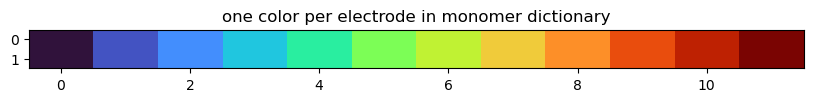

In [5]:
# create a dictionary of electrodes with refs to SIMION elec-adjust assignments and a color for drawings
# adding an entry here for each wire connected to the SLIM

elecDict = {}
colorDict = {}

cm = 'turbo' # feel free to swap this out
# cm = 'YlGnBu' 
# cm = 'spring' # a couple fun cmap options, you generally want a lot of contrast though
cmap = plt.get_cmap(cm)

elecKeys = []
for i in range(numDC): # TW DCs
    elecKeys.append('DC%d'%(i+1))

elecKeys.append("RF1") # RF
elecKeys.append("RF2")

elecKeys.append("G") # 2 sync'd guards use the same voltage, so just one assignment

## add in optional extra electrodes, commented out to optimize use of color range
# elecKeys.append("CE1") # alt design
if symmetry == "'ASY'":
    elecKeys.append("P") # add pusher
    
elecNums =  np.arange(0, len(elecKeys), 1)
numColors = len(elecNums)
colorMap = cmap(np.linspace(0, 0.9, numColors))

for j,k in enumerate(elecKeys):
    elecDict[k] = j+1 #because simion counts from 1
    colorDict[k] = colorMap[j]    

# finished product: combo of electrode names/keys:SIMION assignments and keys:color assignments
elecDefinitions = [elecDict, colorDict] 


# these are all the colors we'll need for our different electrode assignments
plt.figure(figsize = (10,0.5))
grad = np.linspace(0, 0.9, numColors)
grad = np.vstack((grad,grad))
plt.imshow(grad, aspect='auto', cmap = cm)
plt.title("one color per electrode in monomer dictionary")

In [6]:
# save this dictionary to params file to make sure the assignments cary over
elec_table = dict_to_table(elecDict)
paramDict['elecDict'] = [elec_table, '-- elec keys : SIMION adj_elec dexes']
writeParamFile(paramDict, "Extrude_SLIM_Parameters.lua")

Extrude_SLIM_Parameters.lua written to file 



# Drawing Functions

### Particularly important here is plotPolyList(), which allows you to check the polygon list that is being assembled as you draw and return relevant image dimensions for SIMION. Additionally, translatePolyList() allows you to shift and rotate your polygon list (for a monomer or whatever). Polygon lists are python list types, so they can be added together simply:
<code> polymer_polygon_list = monomerA_poly_list + monomerB_poly_list </code>

In [7]:
# some simple functions for quickly creating polygon groups
def drawGrids(drawInstance, imageInstance, step_count = 10):
    '''adds grids to drawing, useful for alternative shapes'''
    y_start = 0
    y_end = image.height
    step_size = int(imageInstance.width / step_count)

    for x in range(0, imageInstance.width, step_size):
        line = ((x, y_start), (x, y_end))
        drawInstance.line(line, fill="gray")

    x_start = 0
    x_end = imageInstance.width

    for y in range(0, imageInstance.height, step_size):
        line = ((x_start, y), (x_end, y))
        drawInstance.line(line, fill="gray") 
    
    print("Step size: %d"%step_size)
    
def rotate(p, origin=(0, 0), degrees=0):
    '''
    Function to rotate a set of coordinates around an origin
    https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
    '''
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)
    

def plotPolyList(polyList, xPixels = monomerLen, yPixels = monomerWidth, colorMap = colorMap, retXY = False, gridBool = False, numGridLines = 10):
    '''
    Assumes rectangles
    Re-draws the polygon coordinates being sent to SIMION, not the image returned from Pillow drawing
    Good sanity check before exporting, use retXY before .gem file creation to get Simulation max XY
    '''
    
    # create pil image
    image = Image.new("RGB", (xPixels, yPixels), "white")
    draw = ImageDraw.Draw(image)
    if gridBool:
        drawGrids(draw, image, numGridLines)    
    
    # cursor / current, either way
    curX = 0
    curY = 0
    
    maxX = 0
    maxY = 0
    
    for i,p in enumerate(polyList):
        
        
        colorIndex = p[0]
        curColor = mpl.colors.to_hex(colorMap[colorIndex-1])
        pCoord = p[2]
        x1 = pCoord[0][0]
        y1 = pCoord[0][1]        
        x2 = pCoord[1][0]
        y2 = pCoord[1][1]        

        draw.rectangle((x1, y1, x2, y2), fill = curColor)
        
        if max(x1, x2) > maxX:
            maxX = max(x1, x2)
    
        if max(y1, y2) > maxY:
            maxY = max(y1, y2)
    
    
    if retXY:
        return maxX, maxY, image
    
    else:
        return image
    
    

def translatePolyList(polyList, dX = 0, dY = 0, origin = (0,0), rotateBool = False, rotateAngle = 0, numDecimals = 1):
    '''The assumption here is that if you are going to rotate, you do that first AND then translate'''
    transPolyList = []
    
    for i,p in enumerate(polyList):
        curCoords = p[2].copy() #print a polylist if you don't know what they look like
        if rotateBool:
            newCoords = rotate(curCoords, origin = origin, degrees = rotateAngle)
        else:
            newCoords = curCoords
        
        x1 = np.around(newCoords[0][0], decimals = numDecimals)
        y1 = np.around(newCoords[0][1], decimals = numDecimals)
        x2 = np.around(newCoords[1][0], decimals = numDecimals)
        y2 = np.around(newCoords[1][1], decimals = numDecimals)
        
        x1+=dX
        y1+=dY        
        x2+=dX
        y2+=dY
        
        newPolyPoint = [p[0], p[1], [(x1,y1),(x2,y2)]]
        
        transPolyList.append(newPolyPoint)
        
    return transPolyList


def polymer_scaler(polymer_polys):
    '''shifts the polymer into the frame based on absolute min X and Y'''
    xlow = 0.0
    ylow = 0.0
    for n, polys in enumerate(polymer_polys):
        if polys[2][0][0] < xlow:
            xlow = polys[2][0][0]
        if polys[2][1][0] < xlow:
            xlow = polys[2][1][0]

        if polys[2][0][1] < ylow:
            ylow = polys[2][0][1]
        if polys[2][1][1] < ylow:
            ylow = polys[2][1][1]

    return xlow, ylow


def polygon_flipper(maxY, polygons):
    '''mirrors polylist in y-dimension to match what will be seen in SIMION'''
    new_polys = []
    for n, poly in enumerate(polygons):
        y1 = poly[2][0][1]
        y2 = poly[2][1][1]
        new_y1 = maxY - y1
        new_y2 = maxY - y2
        
        new_coords = [(poly[2][0][0], new_y1), (poly[2][1][0], new_y2)]
        new_poly =[poly[0], poly[1], new_coords] 
        new_polys.append(new_poly)
    return new_polys

## Generate a Monomer

#### Generate the image and polygon list of a simple monomer, defaulting to above paramDict values. This generates a stock SLIM monomer and will likely require some modifications to stray too far from that. The polygon list for this monomer can be moved and shifted around to extrude a polymeric path or make turns, as will be shown.

In [8]:
def genMonomer(monomerLen, monomerWidth, 
               sp = sp, 
               wGuard = wGuard, 
               wElectrode = wElectrode,
               wRF = wRF, 
               numDC = numDC, 
               numRF = numRF,
               elecDefinitions = elecDefinitions,
               guardBool = [True, True]):

    image = Image.new("RGB", (monomerLen, monomerWidth), "white") # generate pillow image
    draw = ImageDraw.Draw(image)
    
    polyList = [] # list of electrode definitions and polygon dimensions
    elecType = ['box', 'polyline'] # only two types defined at present

    elecDict, colorDict = elecDefinitions # unpack electrode dictionary
    
    ######### Start of TWAVE Segment Generation

    curX = sp/2 # if the spacing between electrods is sp then when we join monomers together the starting point must be sp/2
    yOffset = 0
    startY = wGuard+sp+wRF+sp
    yStep = sp+wRF+sp+wElectrode
    
    xShift = monomerLen

    for n in range(numMonomersX):
        xMod = xShift*n
        ##########
        ###Add TWAVE Electrodes
        for i in range(numDC):
            
            curX= sp/2+(lElectrode+sp)*i

            curY = startY-yStep  
            for j in range(numRowsDC):
                
                elecKey = 'DC%d'%(i+1)
                elecNum = elecDict[elecKey]
                
                curColor = mpl.colors.to_hex(colorDict[elecKey])
                curY += yStep

                x1, y1 = curX+xMod, curY
                x2, y2 = curX+lElectrode+xMod, curY+wElectrode


                #This next line contains the information that will be exported and read by SIMION for the generation of the gem file
                polyList.append([elecNum, elecType[0], [(x1,y1),(x2,y2)]])#use box type for generation of gem file parameters
                #The drawing of the rectangle using Pillow is separate from SIMION but represents what we are after.
                draw.rectangle((x1, y1, x2, y2), fill = curColor)
        #########


    ########
    ### RF Electrodes

    rfPhaseInd = 0
    
    curX= 0
    startY = wGuard+sp
        
    for n in range(numRF):
        m = n%2 # just returns a 0 then a 1
        elecKey = 'RF%d'%(m+1)
        elecNum = elecDict[elecKey]
        curColor = mpl.colors.to_hex(colorDict[elecKey])
        
        
        curY = startY+yStep*n
        x1, y1 = curX, curY
        x2, y2 = curX+totalLen+xMod, curY+wRF

        polyList.append([elecNum, elecType[0], [(x1,y1),(x2,y2)]])
        draw.rectangle((x1, y1, x2, y2), fill = curColor)

    #END RF
    ############


    ############
    #Guards

    elecKey = 'G'
    elecNum = elecDict[elecKey]
    curColor = mpl.colors.to_hex(colorDict[elecKey])   
    
    # Guard-1
    if guardBool[0]:# Top Guard    
        curX = 0
        curY = 0

        x1, y1 = curX, curY
        x2, y2 = curX+totalLen+xMod, curY+wGuard
        
        polyList.append([elecNum, elecType[0], [(x1,y1),(x2,y2)]])
        draw.rectangle((x1, y1, x2, y2), fill = curColor)

    # Guard-2
    if guardBool[1]:
        curX = 0
        curY = totalWidth-wGuard

        x1, y1 = curX, curY
        x2, y2 = curX+totalLen+xMod, curY+wGuard
        
        polyList.append([elecNum, elecType[0], [(x1,y1),(x2,y2)]])
        draw.rectangle((x1, y1, x2, y2), fill = curColor)
    
    
    x1 = 0
    x2 = image.width
    y1 = 0
    y2 = image.height
    
    # if skipping a guard, crop the empty space
    if not guardBool[0]:
        y1+= wGuard
    if not guardBool[1]:
        y2 -= wGuard
    image = image.crop((x1, y1, x2, y2))
    
    #End Guards
    ############
    
    return image, polyList

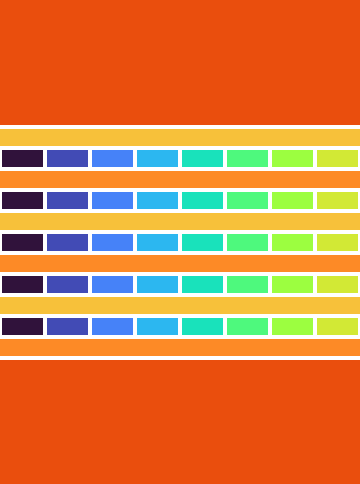

In [9]:
monomer_image, monomer_poly_list = genMonomer(monomerLen, monomerWidth, numDC = numDC, numRF = 6, guardBool = [True, True])
# display(monomer_image) # test that image matches polygon list
plotPolyList(monomer_poly_list)

In [10]:
def genPusherMonomer(monomerLen, monomerWidth, 
               sp = sp, 
               wGuard = wGuard, 
               wElectrode = wElectrode,
               wRF = wRF, 
               numDC = numDC, 
               numRF = numRF,
               elecDefinitions = elecDefinitions,
               guardBool = [True, True]):
    
    image = Image.new("RGB", (monomerLen, monomerWidth), "white") # generate pillow image
    draw = ImageDraw.Draw(image)
    
    polyList = [] #this list is key as it contains electrod definition and coordinates
    elecType = ['box', 'polyline'] #only two types defined at present
    
    elecDict, colorDict = elecDefinitions

    ######### Start of TWAVE Segment Generation

    curX = sp/2 #if the spacing between electrods is sp then when we join monomers together the starting point must be sp/2
    yOffset = 0
    startY = wGuard+sp+wRF+sp
    yStep = sp+wRF+sp+wElectrode

    xShift = monomerLen

    for n in range(numMonomersX):
        xMod = xShift*n
        ##########
        ###Add TWAVE Electrodes
        for i in range(numDC):
            curX= sp/2+(lElectrode+sp)*i

            curY = startY-yStep #0#wGuard+sp#yStep*(numRowsDC-1)    
            for j in range(numRowsDC):
                
                elecKey = 'P'
                elecNum = elecDict[elecKey]
                
                curColor = mpl.colors.to_hex(colorDict[elecKey])
                curY += yStep

                x1, y1 = curX+xMod, curY
                x2, y2 = curX+lElectrode+xMod, curY+wElectrode


                #This next line contains the information that will be exported and read by SIMION for the generation of the gem file
                polyList.append([elecNum, elecType[0], [(x1,y1),(x2,y2)]])#use box type for generation of gem file parameters
                #The drawing of the rectangle using Pillow is separate from SIMION but represents what we are after.
                draw.rectangle((x1, y1, x2, y2), fill = curColor)
        #########


    ########
    ### RF Electrodes

    rfPhaseInd = 0

    curX= 0
    startY = wGuard+sp

    for n in range(numRF):
        m = n%2 # just returns a 0 then a 1
        elecKey = 'P'
        elecNum = elecDict[elecKey]
        curColor = mpl.colors.to_hex(colorDict[elecKey])
        
        curY = startY+yStep*n
        x1, y1 = curX, curY
        x2, y2 = curX+totalLen+xMod, curY+wRF

        polyList.append([elecNum, elecType[0], [(x1,y1),(x2,y2)]])
        draw.rectangle((x1, y1, x2, y2), fill = curColor)


    #END RF
    ############


    ############
    #Guards

    # Guards
    
    elecKey = 'G'
    elecNum = elecDict[elecKey]
    curColor = mpl.colors.to_hex(colorDict[elecKey])
    
    if guardBool[0]:#Top Guard    
        curX = 0
        curY = 0

        x1, y1 = curX, curY
        x2, y2 = curX+totalLen+xMod, curY+wGuard

        polyList.append([elecNum, elecType[0], [(x1,y1),(x2,y2)]])
        draw.rectangle((x1, y1, x2, y2), fill = curColor)

    # Guard-2
    if guardBool[1]:
        curX = 0
        curY = totalWidth-wGuard

        x1, y1 = curX, curY
        x2, y2 = curX+totalLen+xMod, curY+wGuard

        polyList.append([elecNum, elecType[0], [(x1,y1),(x2,y2)]])
        draw.rectangle((x1, y1, x2, y2), fill = curColor)
    

    x1 = 0
    x2 = image.width
    y1 = 0
    y2 = image.height
    
    #is this elegant, no.  Sorry. 
    if not guardBool[0]:
        y1+= wGuard
    if not guardBool[1]:
        y2 -= wGuard
    image = image.crop((x1, y1, x2, y2))
        
    
    #End Guards
    ############
    
    return image, polyList

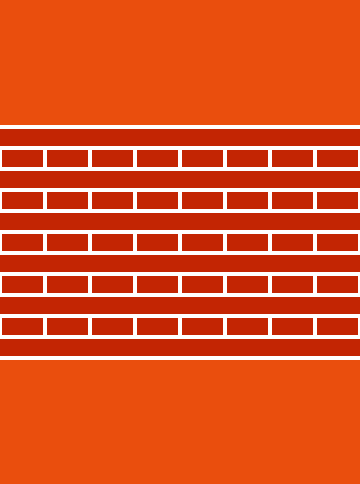

In [11]:
if symmetry == "'ASY'":
    P_image, P_polyList = genPusherMonomer(monomerLen, monomerWidth, guardBool = [True, True])
    display(P_image)

# Functionalizing design from here is relatively simple:

### These are quick functions written to demonstrate the utility of programming polymer extrusion. The first example extrudes a straight path of a desired length. This is just drawn up here, but the code to export it to SIMION is at the bottom. The second generates 90º turns that can be appended. The final builds off of these two base functions to extrude the path laid out in the SLIM pickins string.

## Example 1: Extrude to Polymeric Separation Length

separation length =  36.576 mm


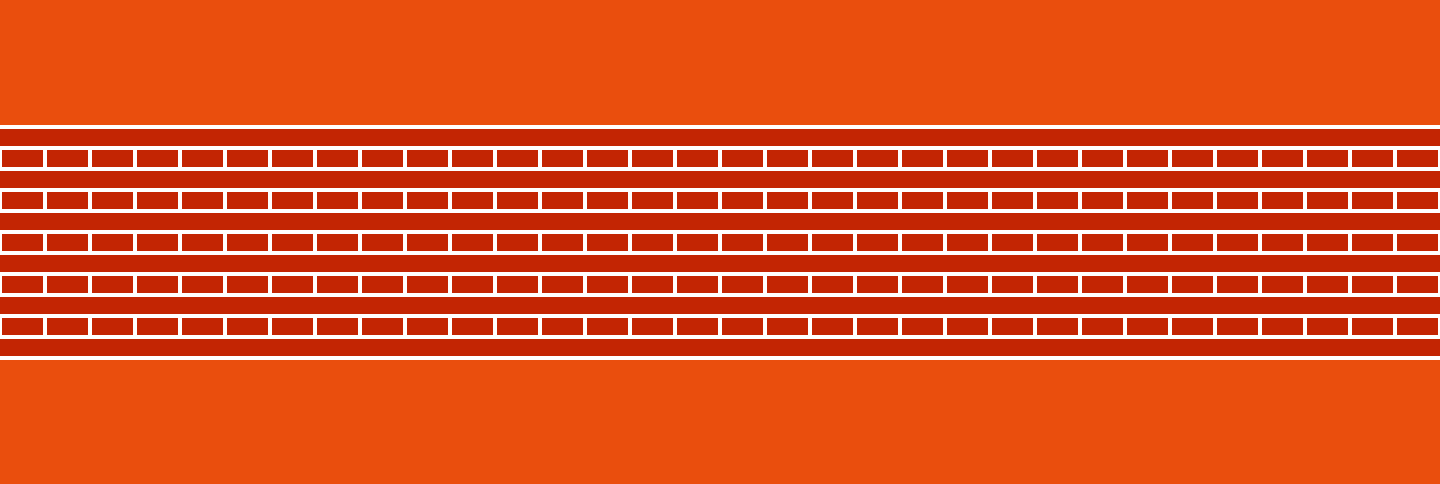

In [12]:
def extrudePolymer(monomer_polys, length, retXY=False):
    '''
    takes in polygon list for monomer, returns one for a polymer
    monomer_polys is the appropriate poly_list
    length is in monomers, = total final length
    '''
    monomer_copy = monomer_polys.copy()
    polymer_polys = monomer_copy.copy() # need to make copies so they don't recursively edit each other
    
    monoX, monoY, im = plotPolyList(monomer_copy, retXY=True)
    for n in range(length-1):
        add_piece = translatePolyList(monomer_copy, dX = (monoX*(n+1)), dY = 0)
        polymer_polys+=add_piece
    
    polyX, polyY, poly_im = plotPolyList(polymer_polys, retXY=True)
    
    if retXY:
        return polyX, polyY, polymer_polys
    else:
        return polymer_polys
    
    
    
# extrude a pentamer SLIM path
polymer_length = 4
print('separation length = ', polymer_length*monomerLen*pixelScale, 'mm')

tetramer_maxX, tetramer_maxY, tetramer_polys = extrudePolymer(monomer_poly_list, length = polymer_length, retXY=True)
plotPolyList(tetramer_polys, xPixels = tetramer_maxX, yPixels = tetramer_maxY)

# if asymmetric
if symmetry == "'ASY'":
    P_tetramer_polys = extrudePolymer(P_polyList, length = polymer_length, retXY=False)
    asy_img = plotPolyList(P_tetramer_polys, xPixels = tetramer_maxX, yPixels = tetramer_maxY)
    display(asy_img)



## Example 2: Simple Turn Generator

In [13]:
def makeGuard(gLen = monomerLen, gHeight =  wGuard, xOffset = 0, yOffset = 0, rotation = 0, gElec = elecNums[-1], gColor = colorMap[-1]):
    xPixels = gLen+xOffset
    yPixels = gHeight+yOffset

    image = Image.new("RGB", (xPixels, yPixels), "white")
    draw = ImageDraw.Draw(image)


    curX = xOffset #if the spacing between electrods is sp then when we join monomers together the starting point must be sp/2
    curY = yOffset

    polyList = [] #this list is key as it contains electrod definition and coordinates
    elecKey = 'G'
    elecNum = elecDict[elecKey]
    curColor = mpl.colors.to_hex(colorDict[elecKey]) 
    elecType = 'box' #, 'polyline'] #only two types defined at present
    
    
    x1, y1 = curX, curY
    x2, y2 = curX+gLen, curY+gHeight

    polyList.append([elecNum, elecType, [(x1,y1),(x2,y2)]])
    
    
    
    draw.rectangle((x1, y1, x2, y2), fill = curColor)
    
    return image, polyList

def makeNinetyTurn(monomer_polys, direction, minimalist=False, display=False, rotate_degs=90, asy=False):
    '''
    Easy to functionalize turns for easy GUI interaction, iterative programmatic simulation generation, etc.
    '''
    
    mono_copy = monomer_polys.copy()
    if direction =='Left':
        rotate_degs += 180
        if asy:
            turn_piece = translatePolyList(genPusherMonomer(monomerLen, monomerWidth, guardBool=[False, True])[1],rotateBool=True, rotateAngle=rotate_degs)
        else:
            turn_piece = translatePolyList(genMonomer(monomerLen, monomerWidth, guardBool=[False, True])[1],rotateBool=True, rotateAngle=rotate_degs)
        turn_piece = translatePolyList(turn_piece, abs(polymer_scaler(turn_piece)[0]), abs(polymer_scaler(turn_piece)[1]))
        x_drop = monomerLen-wGuard-sp
        y_drop = (monomerWidth - monomerLen)-wGuard-sp#  -wGuard # -sp # -(lElectrode)
        turn_piece = translatePolyList(turn_piece, dX = x_drop, dY = y_drop)
        guard_piece = translatePolyList(makeGuard(trackWidth+wGuard, wGuard)[1], dX=monomerLen-sp, dY=totalWidth-wGuard)
        
        
    if direction =='Right':
        if asy:
            turn_piece = translatePolyList(genPusherMonomer(monomerLen, monomerWidth, guardBool=[True, False])[1],rotateBool=True, rotateAngle=rotate_degs)
        else:
            turn_piece = translatePolyList(genMonomer(monomerLen, monomerWidth, guardBool=[True, False])[1],rotateBool=True, rotateAngle=rotate_degs)
        turn_piece = translatePolyList(turn_piece, abs(polymer_scaler(turn_piece)[0]), abs(polymer_scaler(turn_piece)[1]))
        x_drop = monomerLen
        y_drop = wGuard+sp
        turn_piece = translatePolyList(turn_piece, dX = x_drop, dY = y_drop)
        guard_piece = translatePolyList(makeGuard(trackWidth+wGuard, wGuard)[1], dX=monomerLen-sp, dY=0)
   
    mono_copy+=turn_piece
    mono_copy+=guard_piece
    turn_polys = mono_copy
    minimalist_turn = turn_piece + guard_piece    
    
    if minimalist:
        turnMaxX, turnMaxY, turn_im = plotPolyList(minimalist_turn, retXY=True, xPixels=monomerLen*2, yPixels = monomerWidth)
        return turn_im, minimalist_turn
    else:
        turnMaxX, turnMaxY, turn_im = plotPolyList(mono_copy, retXY=True, xPixels=monomerLen*2, yPixels = monomerWidth)
        return turn_im, turn_polys

715.0 489.0


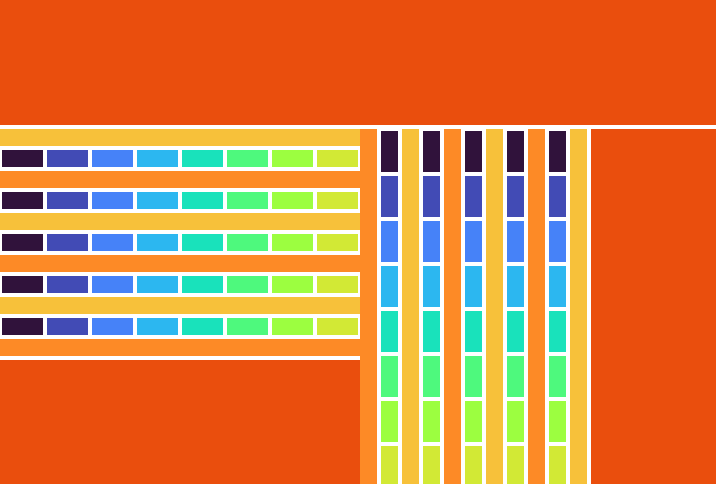

In [14]:
turn_im, turn_polys = makeNinetyTurn(monomer_poly_list, direction="Right", minimalist=False, display = True)
turn_maxX, turn_maxY, turn_im2 = plotPolyList(turn_polys, monomerLen*2, monomerWidth, retXY=True)
print(turn_maxX, turn_maxY)
display(turn_im2)

715.0 489.0


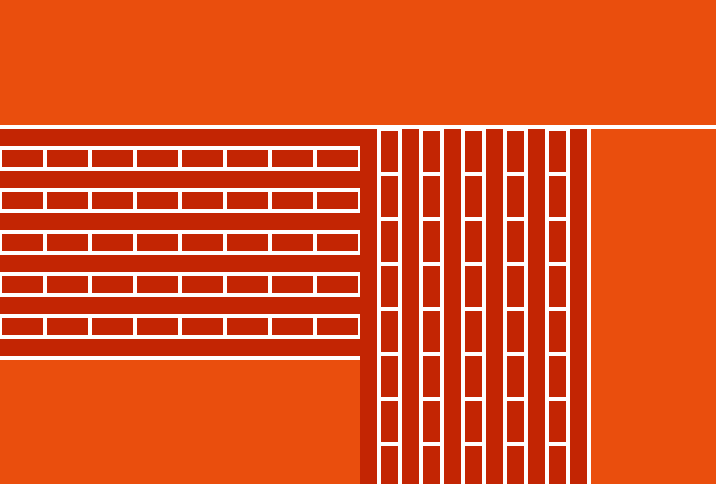

In [15]:
if symmetry == "'ASY'":
    turn_im, turn_polys = makeNinetyTurn(P_polyList, direction="Right",asy = True, minimalist=False, display = True)
    turn_maxX, turn_maxY, turn_im2 = plotPolyList(turn_polys, monomerLen*2, monomerWidth, retXY=True)
    print(turn_maxX, turn_maxY)
    display(turn_im2)

## Example 3: SLIM Pickins Style Implementation:

In [16]:
# SLIM Pickins uses strings to determine directional ordering
def pickinsInterpreter(string, monomer_polys, retXY=False, asy=False):
    '''take in SLIM Pickins string and return SIMION workspace'''
    
    new_mono = monomer_polys.copy()
    poly_build = new_mono.copy()
    
    rotation = 0.0
    curX = 0.0
    curY = 0.0
    
    for n, direc in enumerate(string):
        
        if n ==0: # currently defualts to starting with a forward piece
            continue
        
        if direc == 'F':
            curX += monomerLen*np.cos(rotation*(np.pi/180)) # if side to side, add monomerLength
            curY += monomerLen*np.sin(rotation*(np.pi/180)) # if up and down, add monomer Length to Y
            poly_build += translatePolyList(new_mono, dX = curX, dY = curY, rotateBool=True, rotateAngle=rotation)

            
        if direc == 'L':
            # first: trim the previous guard on the inside turn - not very elegant
            # guard 1 = inside guard on L turn, guard 2 = inside on R turn
            guard = poly_build[-2]
            ng_lo = (min(guard[2][0][0], guard[2][1][0])-(sp*round(np.cos(rotation*np.pi/180))), min(guard[2][0][1], guard[2][1][1])-(sp*round(np.sin(rotation*np.pi/180))))
            ng_hi = (max(guard[2][0][0], guard[2][1][0])-(sp*round(np.cos(rotation*np.pi/180))), max(guard[2][0][1], guard[2][1][1])-(sp*round(np.sin(rotation*np.pi/180))))
            guard[2] = [ng_lo, ng_hi] # save adusted guard
            
            # add turn piece
            turn = makeNinetyTurn(monomer_polys, "Left", minimalist=True, asy=asy)[1]
            poly_build += translatePolyList(turn, dX = curX, dY = curY, rotateBool=True, rotateAngle=rotation)
            
            # update cursor and rotation
            curX += np.cos(rotation*(np.pi/180)) * (monomerLen-wGuard-sp) + round((np.sin(rotation*(np.pi/180)))*(-(monomerWidth-wGuard-sp)))
            curY += np.cos(rotation*(np.pi/180)) * (monomerLen-sp) + (np.sin(rotation*(np.pi/180))*(monomerLen-wGuard-sp))
            rotation -= 90
            
        if direc=='R':
            # first: trim the previous guard on the inside turn
            guard = poly_build[-1]
            ng_lo = (min(guard[2][0][0], guard[2][1][0])-(sp*round(np.cos(rotation*np.pi/180))), min(guard[2][0][1], guard[2][1][1])-(sp*round(np.sin(rotation*np.pi/180))))
            ng_hi = (max(guard[2][0][0], guard[2][1][0])-(sp*round(np.cos(rotation*np.pi/180))), max(guard[2][0][1], guard[2][1][1])-(sp*round(np.sin(rotation*np.pi/180))))
            guard[2] = [ng_lo, ng_hi] # save adusted guard
            
            # add turn piece
            turn = makeNinetyTurn(monomer_polys, "Right", minimalist=True, asy=asy)[1]
            poly_build += translatePolyList(turn, dX = curX, dY = curY, rotateBool=True, rotateAngle=rotation)
            
            # update cursor and rotation
            curX += round(np.cos(rotation*(np.pi/180))) * (monomerLen+(monomerWidth-wGuard)-sp) + (np.sin(rotation*(np.pi/180))*(-wGuard-sp))
            curY += round(np.cos(rotation*(np.pi/180))) * (wGuard+sp) + (np.sin(rotation*(np.pi/180))*(monomerLen+(monomerWidth-wGuard)-sp))
            rotation += 90
            

    # shift image into frame and scale figure      
    lowX, lowY = polymer_scaler(poly_build)
    scaled = translatePolyList(poly_build, dY = abs(lowY), dX = abs(lowX))
    maxX, maxY, im = plotPolyList(scaled, monomerLen*8, monomerWidth*8, retXY=True)
    
    # flip polygons in y-dimension to match SIMION coord-system
    flip_polys = polygon_flipper(maxY, scaled)

    if retXY:
        return maxX, maxY, flip_polys, im
    else:
        display(im)
        return flip_polys, im

FFFLFFLFFRFFRFFF
1569.0


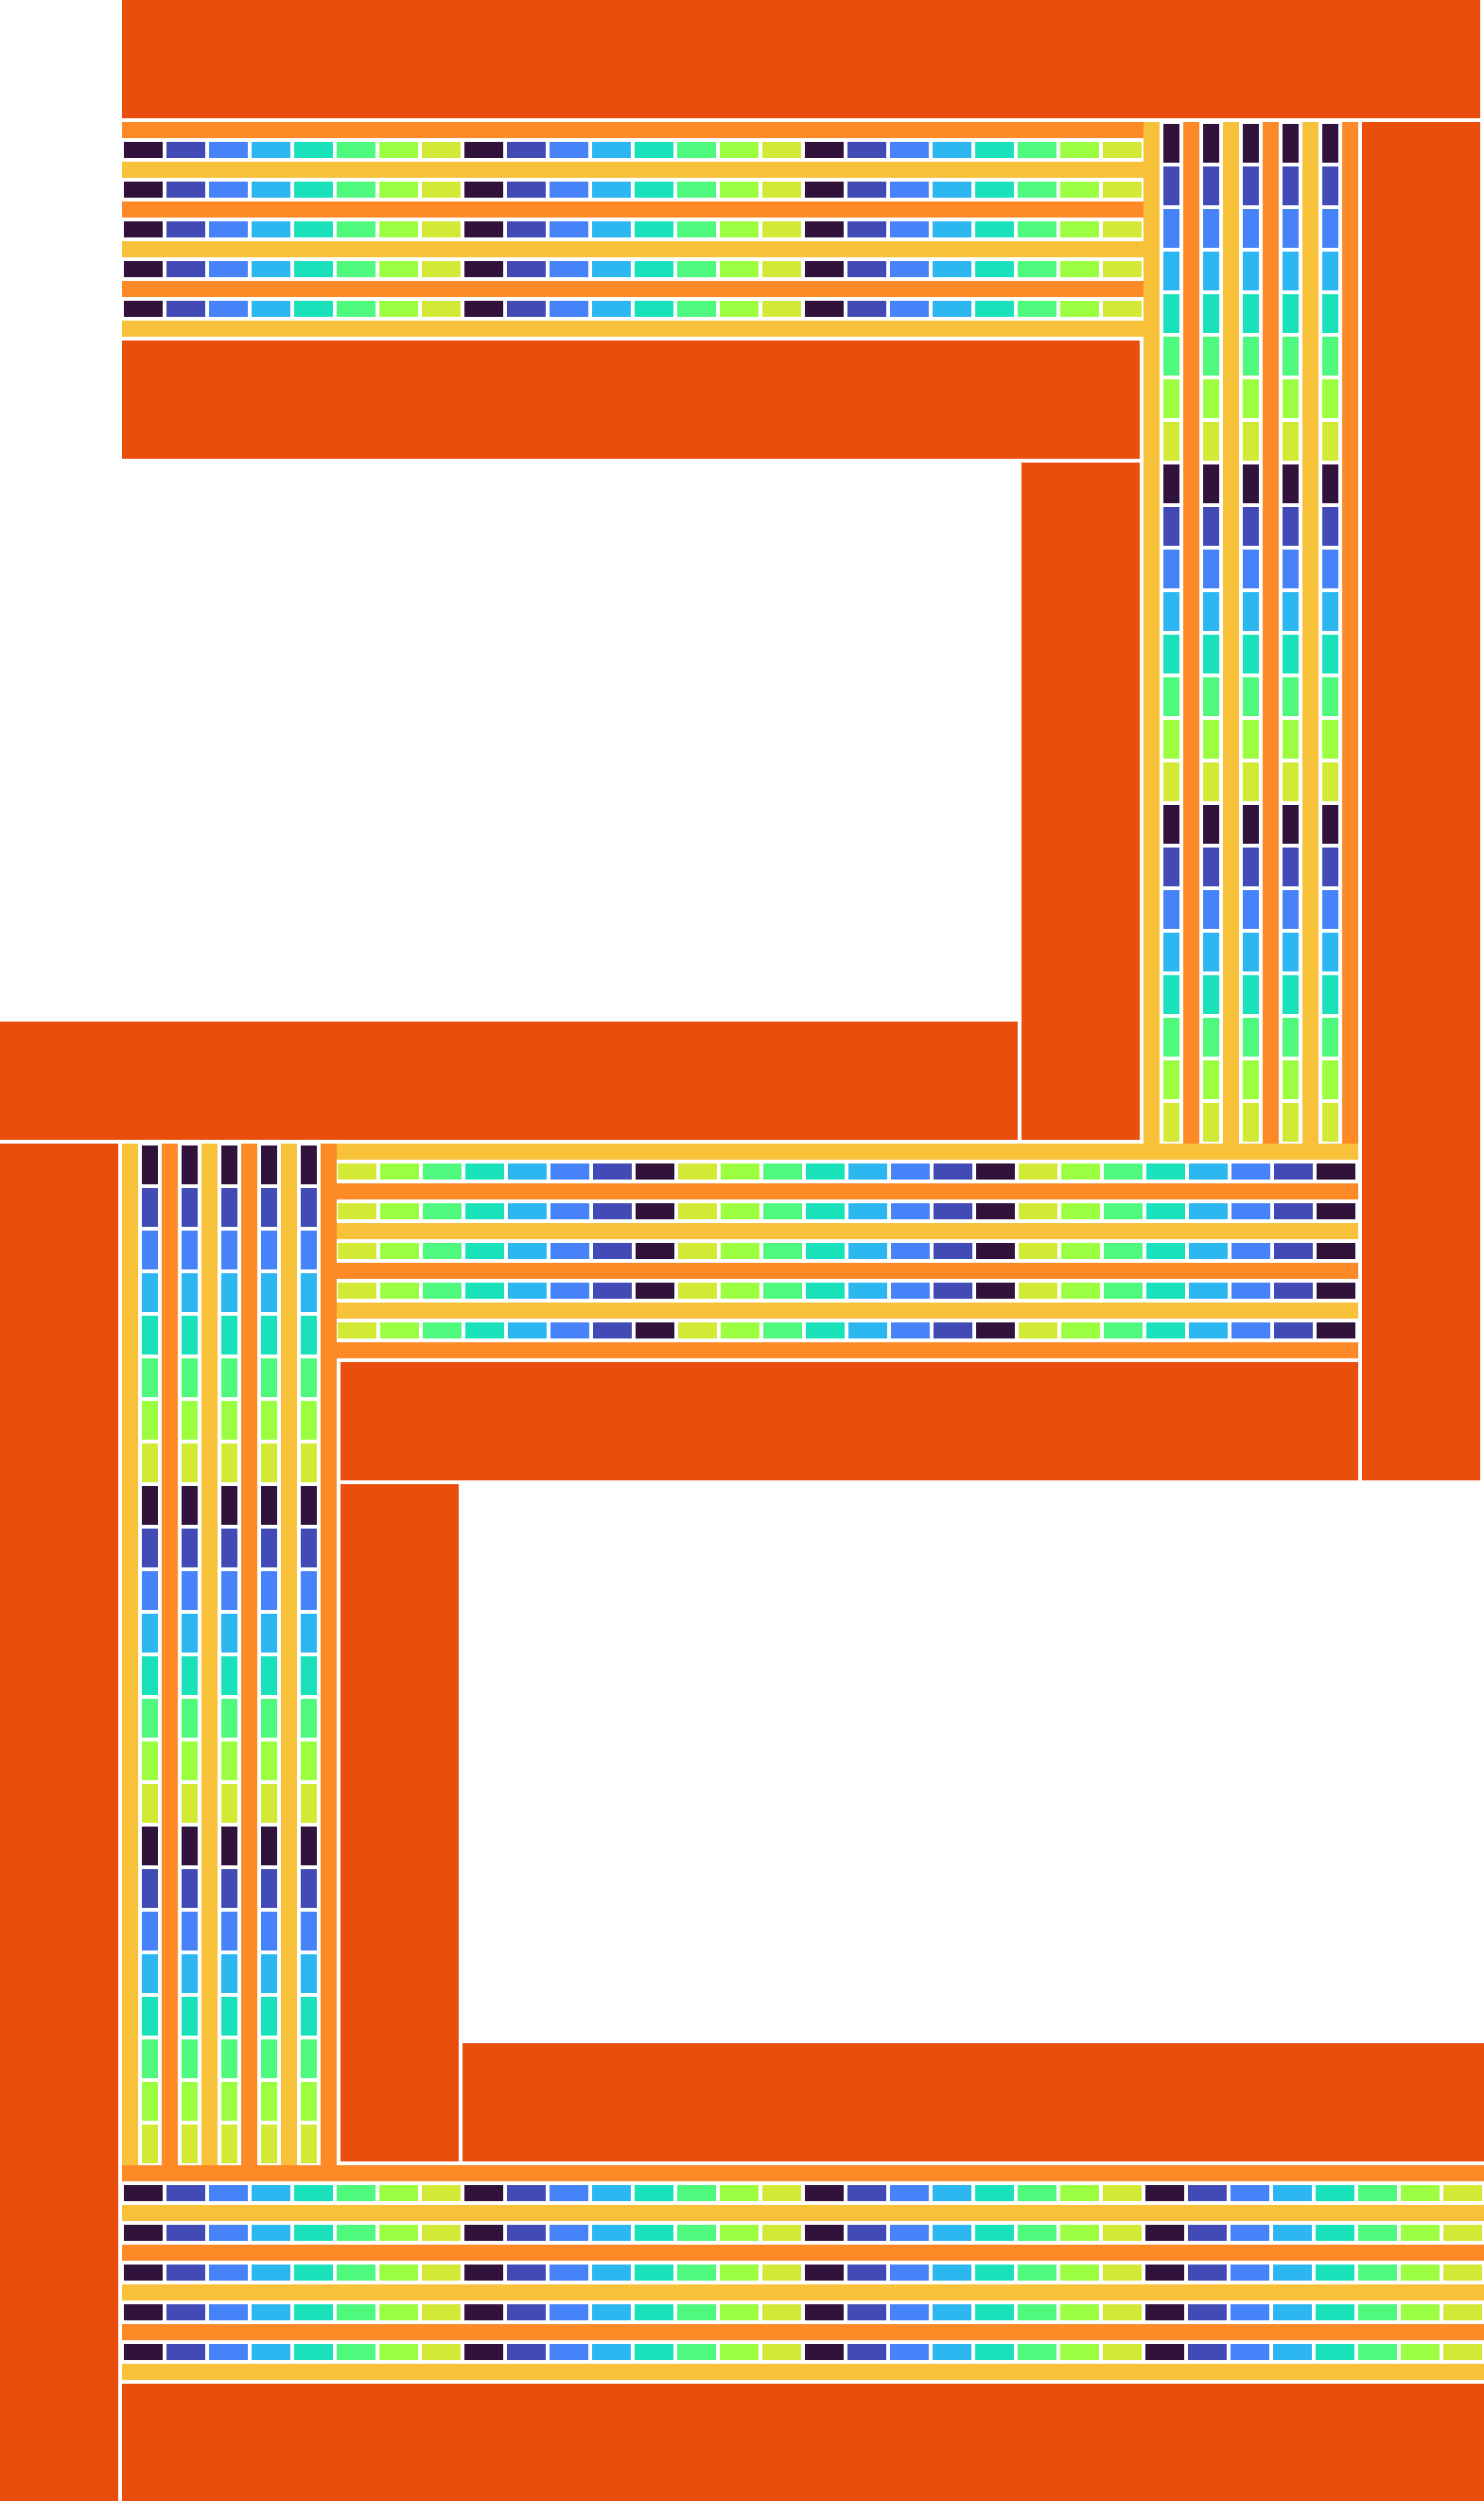

In [17]:
# typing in a slim pickins string to export a sim 
pick_string = 'FFFLFFLFFRFFRFFF'
polymaxX, polymaxY, build_polys, im = pickinsInterpreter(pick_string, monomer_poly_list, retXY=True)
print(pick_string)

print(polymaxX)
# plotting polygons shows y-axis mirror of what you've made, to check the real version, use display(image)
plotPolyList(build_polys, round(polymaxX), round(polymaxY))

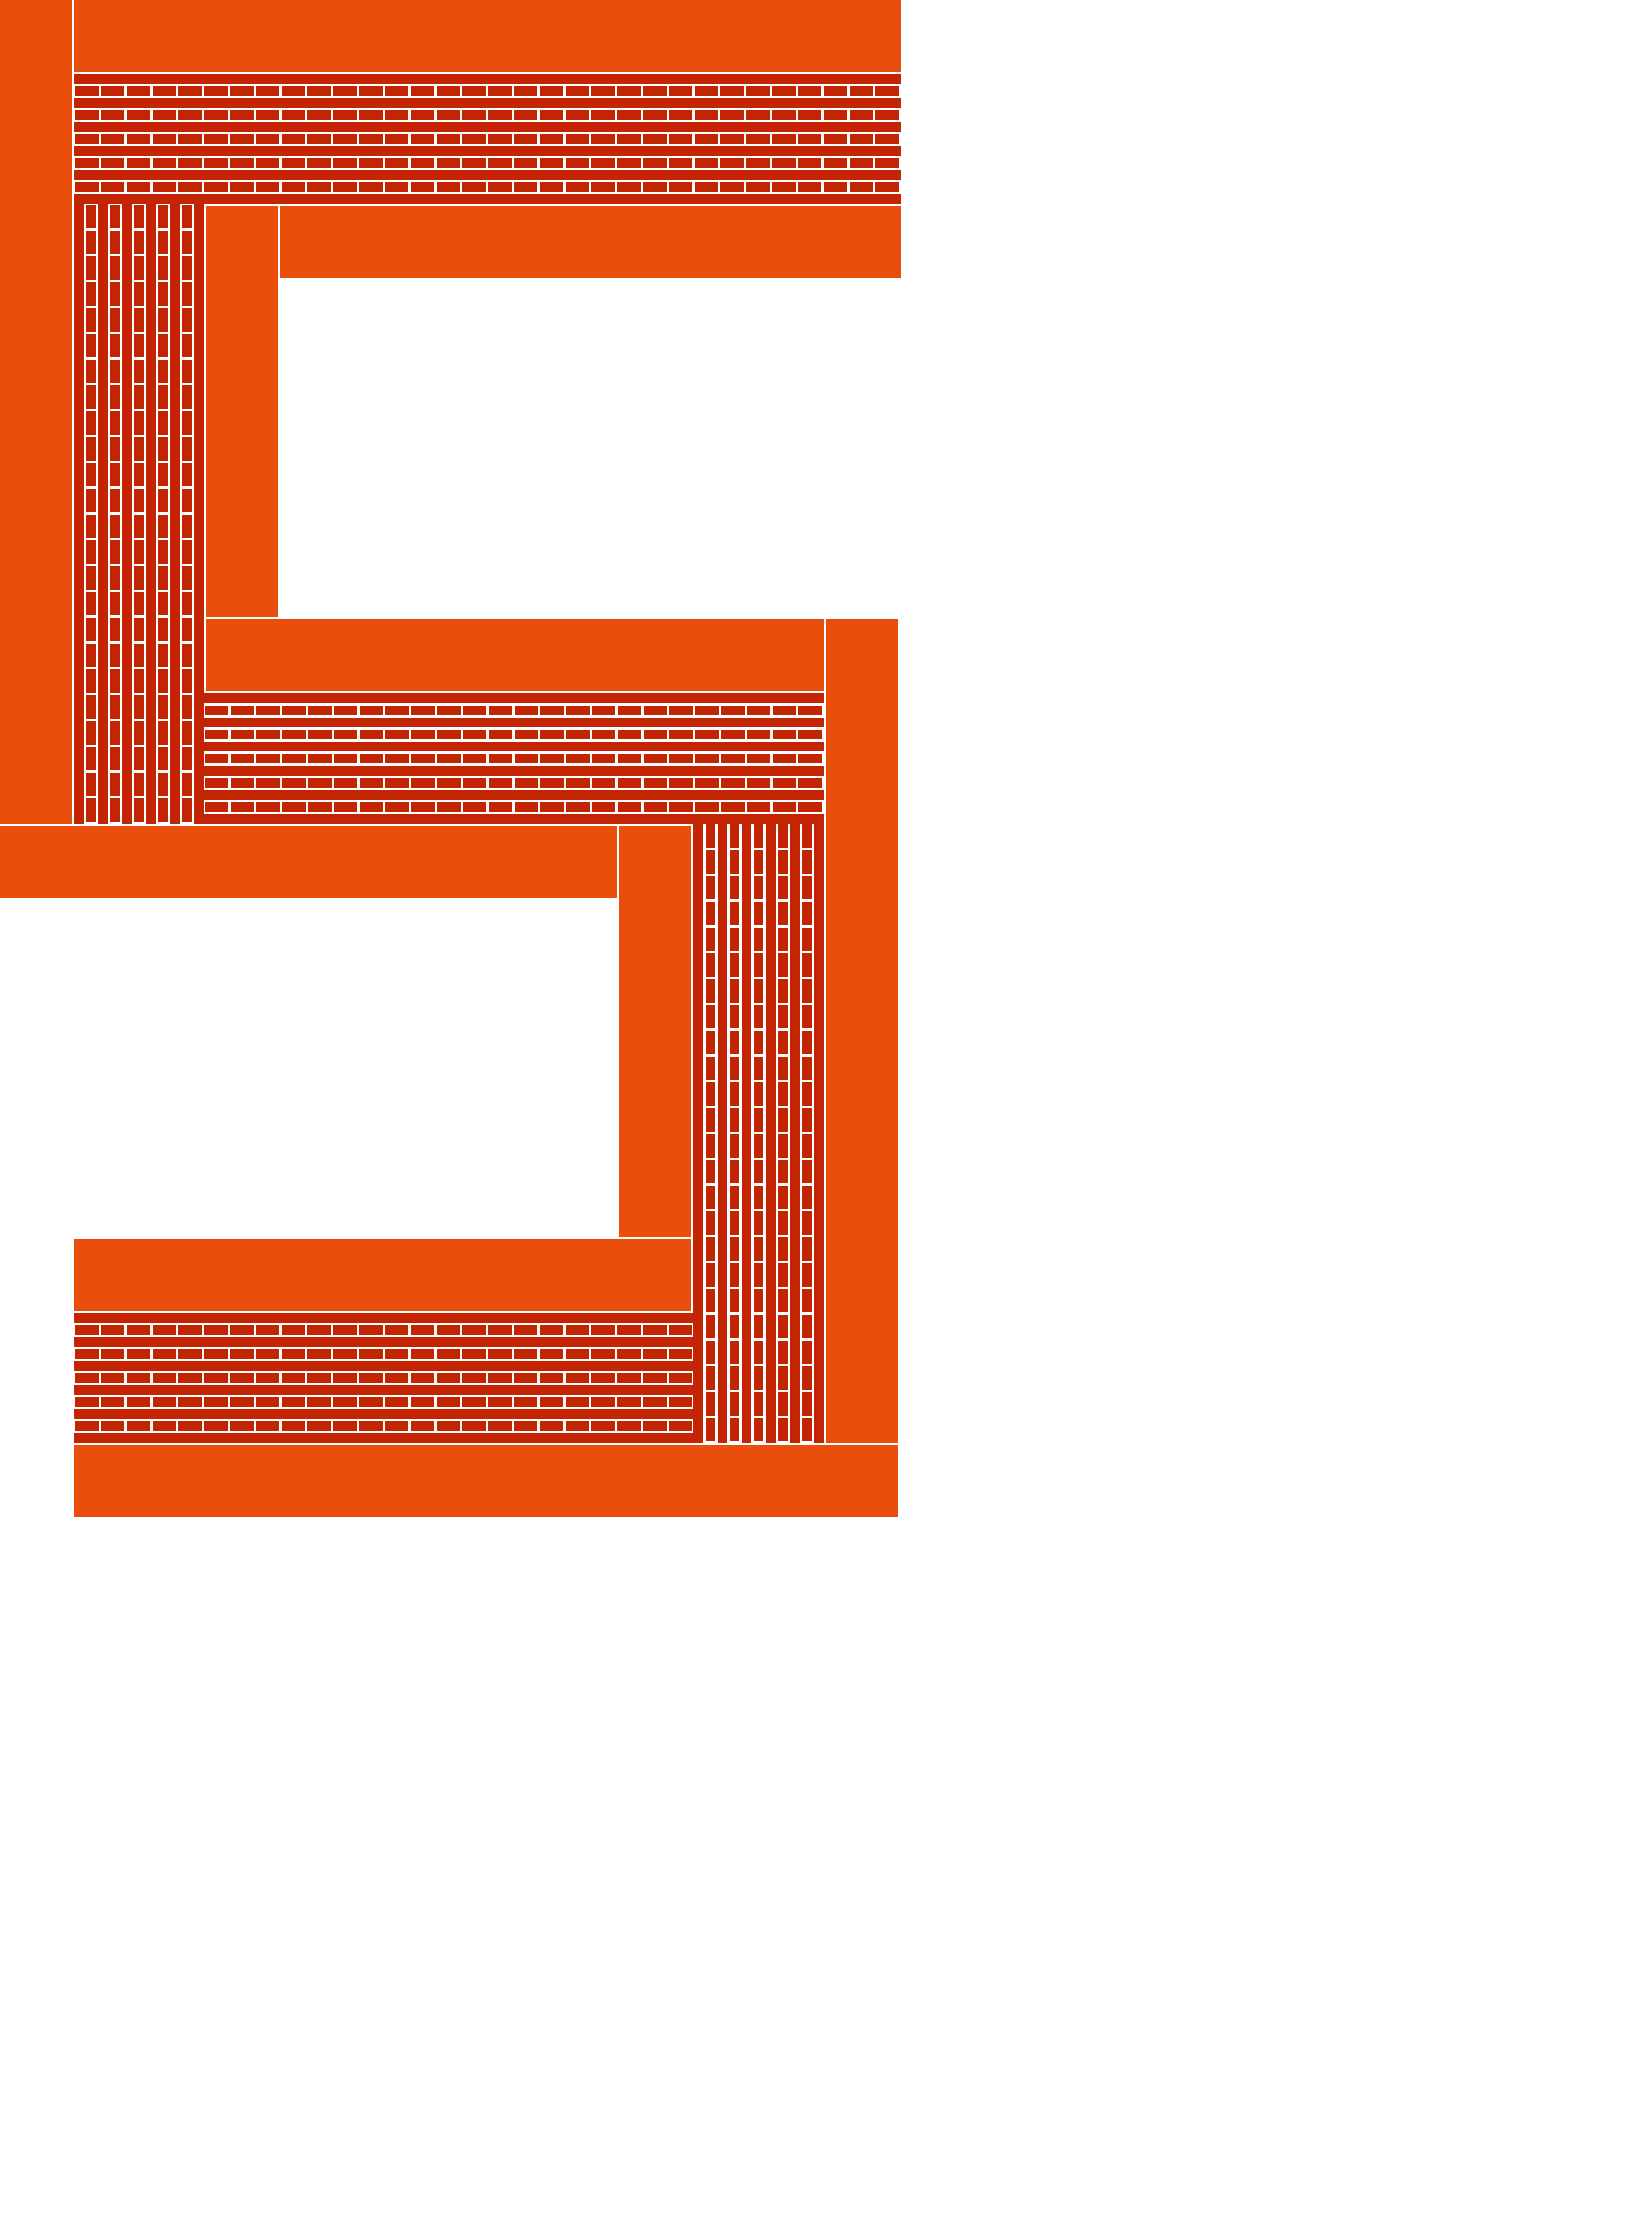

In [18]:
if symmetry == "'ASY'":
    polymaxX, polymaxY, asy_build_polys, im = pickinsInterpreter(pick_string, P_polyList, asy = True, retXY=True)
    display(im)

# Export to SIMION

### 1. Updated Simulation Parameters

In [19]:
# update our param dictionary to the new simulation length and width, and re-export
# this is critical for the SIMION space to match our image size

paramDict['totalLen'] = [polymaxX*pixelScale, '--Total Length of the monomer (mm)']
paramDict['totalWidth'] = [polymaxY*pixelScale, '--Total Width of the monomer (mm)']

# let's also add a name for our creation:
design_name = "'pickins_test'"
if symmetry == "'ASY'":
    design_name = "'ASY_pickins_test'"
paramDict['design_title'] = [design_name, '--  Name for associated files']


print("%s"%design_name[1:-1])
writeParamFile(paramDict, "Extrude_SLIM_Parameters.lua") # find a way to nameswap if desired
!cat "Extrude_SLIM_Parameters.lua"

ASY_pickins_test
Extrude_SLIM_Parameters.lua written to file 

Symmetry = 'ASY'    --Field Symmetry
wElectrode = 0.4064    --Width of the DC electrode (mm)
lElectrode = 1.016    --Length of the DC electrode (mm)
wRF = 0.4064    --Width of the RF (mm)
wGuard = 3.1496    --Width of the Guard (mm)
sp = 0.127    --Spacing between electrodes (mm)
numDC = 8    --Number of DC electrodes per TW Segment
numRowsDC = 5    --Number of rows of TWAVE segments
numRF = 6    --Number of RF Segments
numGuards = 2    --Number of Guard Segments
totalLen = 39.852599999999995    --Total Length of the monomer (mm)
totalWidth = 67.1576    --Total Width of the monomer (mm)
trackWidth = 5.9944    --Track Width (mm)
d = 1.5875    -- half distance between the layers/boards (mm)
elecDict = {["DC1"] = 1, ["DC2"] = 2, ["DC3"] = 3, ["DC4"] = 4, ["DC5"] = 5, ["DC6"] = 6, ["DC7"] = 7, ["DC8"] = 8, ["RF1"] = 9, ["RF2"] = 10, ["G"] = 11, ["P"] = 12}    -- elec keys : SIMION adj_elec dexes
design_title = 'ASY_pickins_test

### 2. Extrude electrodes to 3D, Export gem File

In [20]:
  # d # 1/2 the distance between the boards in mm
eThickness = 0.2 #200 um thick electrodes for simulation
print(d, d+eThickness) #thinking about the distance between planes (0.2 would be electrodes that are 200 um thick)

elecStrMirr = '''
\te(%d)
\t{
\t\textrude_xy('''+str(d)+', '+str(round(d+eThickness, 4))+'''){%s}
\t}
'''

elecStr1 = '''
\te(%d)
\t{
\t\textrude_xy(0.0, '''+str(eThickness)+'''){%s}
\t}
'''
elecStr2 = '''
\te(%d)
\t{
\t\textrude_xy('''+str((d*2)+eThickness)+', '+str(round((d*2)+eThickness*2, 3))+'''){%s}
\t}
'''
print(elecStrMirr)

print(elecStr1)

print(elecStr2)

1.5875 1.7874999999999999

	e(%d)
	{
		extrude_xy(1.5875, 1.7875){%s}
	}


	e(%d)
	{
		extrude_xy(0.0, 0.2){%s}
	}


	e(%d)
	{
		extrude_xy(3.375, 3.575){%s}
	}



In [21]:
def genGemStr(polyList, elecStr = elecStrMirr, gemStr = '', pixelScale = pixelScale):
    '''
    Accepts a list of polynomials or boxes as defined in your SLIM to simulate
    Accepts the electrode string as a basis for this expansion
    The pixelScale is essential to translate your values in mils to the SIMION values in mm
    '''
    for elecDef in polyList:
        curElec = elecDef[0]
        curType = elecDef[1]
        poly = elecDef[2]
        polyStr = '%s('%curType
        for i,p in enumerate(poly):
            polyStr+='%.3f'%(p[0]*pixelScale)
            polyStr+=','
            polyStr+='%.3f'%(p[1]*pixelScale)
            polyStr+=', '
        polyStr = polyStr[0:-1]
        polyStr += ')'

        curElecStr = elecStrMirr%(curElec, polyStr)
        gemStr += curElecStr
    return gemStr

def saveGEMFile(gemStr, fileName = 'user.gem'):
    f = open(fileName, 'w')
    f.write(gemStr)
    f.close()
    print("%s written to disk"%fileName)
    
def genAsyGemStr(RFpolyList, pusherPolyList, gemStr='', pixelScale=pixelScale):
    '''
    Switching the lua code to not mirror the board means the pusher must be physically coded
    
    '''
    for elecDef in RFpolyList:
        curElec = elecDef[0]
        curType = elecDef[1]
        poly = elecDef[2]
        polyStr = '%s('%curType
        for i,p in enumerate(poly):
            polyStr+='%.3f'%(p[0]*pixelScale)
            polyStr+=','
            polyStr+='%.3f'%(p[1]*pixelScale)
            polyStr+=', '
        polyStr = polyStr[0:-1]
        polyStr += ')'
        
        curElecStr = elecStr1%(curElec, polyStr)
        gemStr += curElecStr
    
    for elecDef in pusherPolyList:
        curElec = elecDef[0]
        curType = elecDef[1]
        poly = elecDef[2]
        polyStr = '%s('%curType
        for i,p in enumerate(poly):
            polyStr+='%.3f'%(p[0]*pixelScale)
            polyStr+=','
            polyStr+='%.3f'%(p[1]*pixelScale)
            polyStr+=', '
        polyStr = polyStr[0:-1]
        polyStr += ')'
        curElecStr = elecStr2%(curElec, polyStr)
        gemStr += curElecStr

    return gemStr

In [22]:
gemStr = genGemStr(build_polys)
print(len(gemStr))

if symmetry == "'ASY'":
    asyGemStr = genAsyGemStr(build_polys, asy_build_polys)
    print(len(asyGemStr))

# this is the electrode geometry file that will be read by our setup lua on init in SIMION
saveGEMFile(gemStr, 'user.gem')

59209
112962
user.gem written to disk


### 3. Custom Particle Definitions

In [23]:
# there is access to defining particles from within SIMION, 
# but could set them to automatically start and stop at simulation front and back

def start_and_stop(poly_list, maxes = (polymaxX, polymaxY), stop_mer=-1, point_start=False, plotBool=False):
    '''takes in polylist, returns start and stop planes for ions'''
    
    # x, y of 13th electrode is DC 3 in third row, find more pythonic way to find that though
    start_x = ((poly_list[12][2][1][0] + poly_list[12][2][0][0])/2)*pixelScale
    start_y = ((poly_list[12][2][1][1] + poly_list[12][2][0][1])/2)*pixelScale
    if symmetry == "'SYM'":
        start_z = 0.0
    elif symmetry == "'ASY'":
        start_z = d
    
    # stop should be a line over the end of the track
    # in this case, 48 electrodes per monomer
    elecs_per_mono = (numDC*numRowsDC) + numRF + numGuards
    
    # stopping plane
    stop_x_lo = 100000.0
    stop_x_hi = 0.0
    stop_y_lo = 100000.0
    stop_y_hi = 0.0
    
    if stop_mer < 0 :
        stop_mer = int(len(poly_list)/elecs_per_mono)
    if stop_mer:
        
        # electrodes in selected polymer index
        for electrode in poly_list[((stop_mer-1) * elecs_per_mono) : (stop_mer*elecs_per_mono)]:
            
            # very ugly chunk that finds splat barrier for selected polymer index
            if electrode[0] == numDC: # if electrode is in the last TW row of the selected
                if electrode[2][0][0] < stop_x_lo or electrode[2][1][0] < stop_x_lo:
                    if electrode[2][0][0] < electrode[2][1][0]:
                        stop_x_lo = electrode[2][0][0]
                    else:
                        stop_x_lo = electrode[2][1][0]
                if electrode[2][0][0]  > stop_x_hi or electrode[2][1][0] > stop_x_hi:
                    if electrode[2][0][0] > electrode[2][1][0]:
                        stop_x_hi = electrode[2][0][0]
                    else:
                        stop_x_hi = electrode[2][1][0]
                if electrode[2][0][1] < stop_y_lo or electrode[2][1][1] < stop_y_lo:
                    if electrode[2][0][1] < electrode[2][1][1]:
                        stop_y_lo = electrode[2][0][1]
                    else:
                        stop_y_lo = electrode[2][1][1]
                if electrode[2][0][1] > stop_y_hi or electrode[2][1][1] > stop_y_hi:
                    if electrode[2][0][1] > electrode[2][1][1]:
                        stop_y_hi = electrode[2][0][1]
                    else:
                        stop_y_hi = electrode[2][1][1]                                
        
        # whichever difference is larger, that is the finish-line width, extend that
        if abs(stop_x_lo - stop_x_hi) > abs(stop_y_lo - stop_y_hi):
            stop_x_lo -= 60
            stop_x_hi += 60
        else:
            stop_y_lo -= 60
            stop_y_hi += 60

    rectangle = [stop_x_lo, stop_y_lo, stop_x_hi, stop_y_hi] # finish line
    
    if plotBool:
        lowX, lowY = polymer_scaler(poly_list)
        scaled = translatePolyList(poly_list, dY = abs(lowY), dX = abs(lowX))
        image = plotPolyList(scaled, int(maxes[0]), int(maxes[1]))
        draw = ImageDraw.Draw(image)
        draw.rectangle(rectangle, fill = 'red') # finish line
        
        start_ellipse = [(start_x/pixelScale-40, start_y/pixelScale-40), (start_x/pixelScale+40, start_y/pixelScale+40)]
        draw.ellipse(start_ellipse, fill='green')
        display(image.transpose(method = Image.Transpose.FLIP_TOP_BOTTOM))
    
        
    sim_rectangle = [round((px * pixelScale), 2) for px in rectangle]
    
    start, stop = (start_x, start_y, start_z),  sim_rectangle
    
    return start, stop

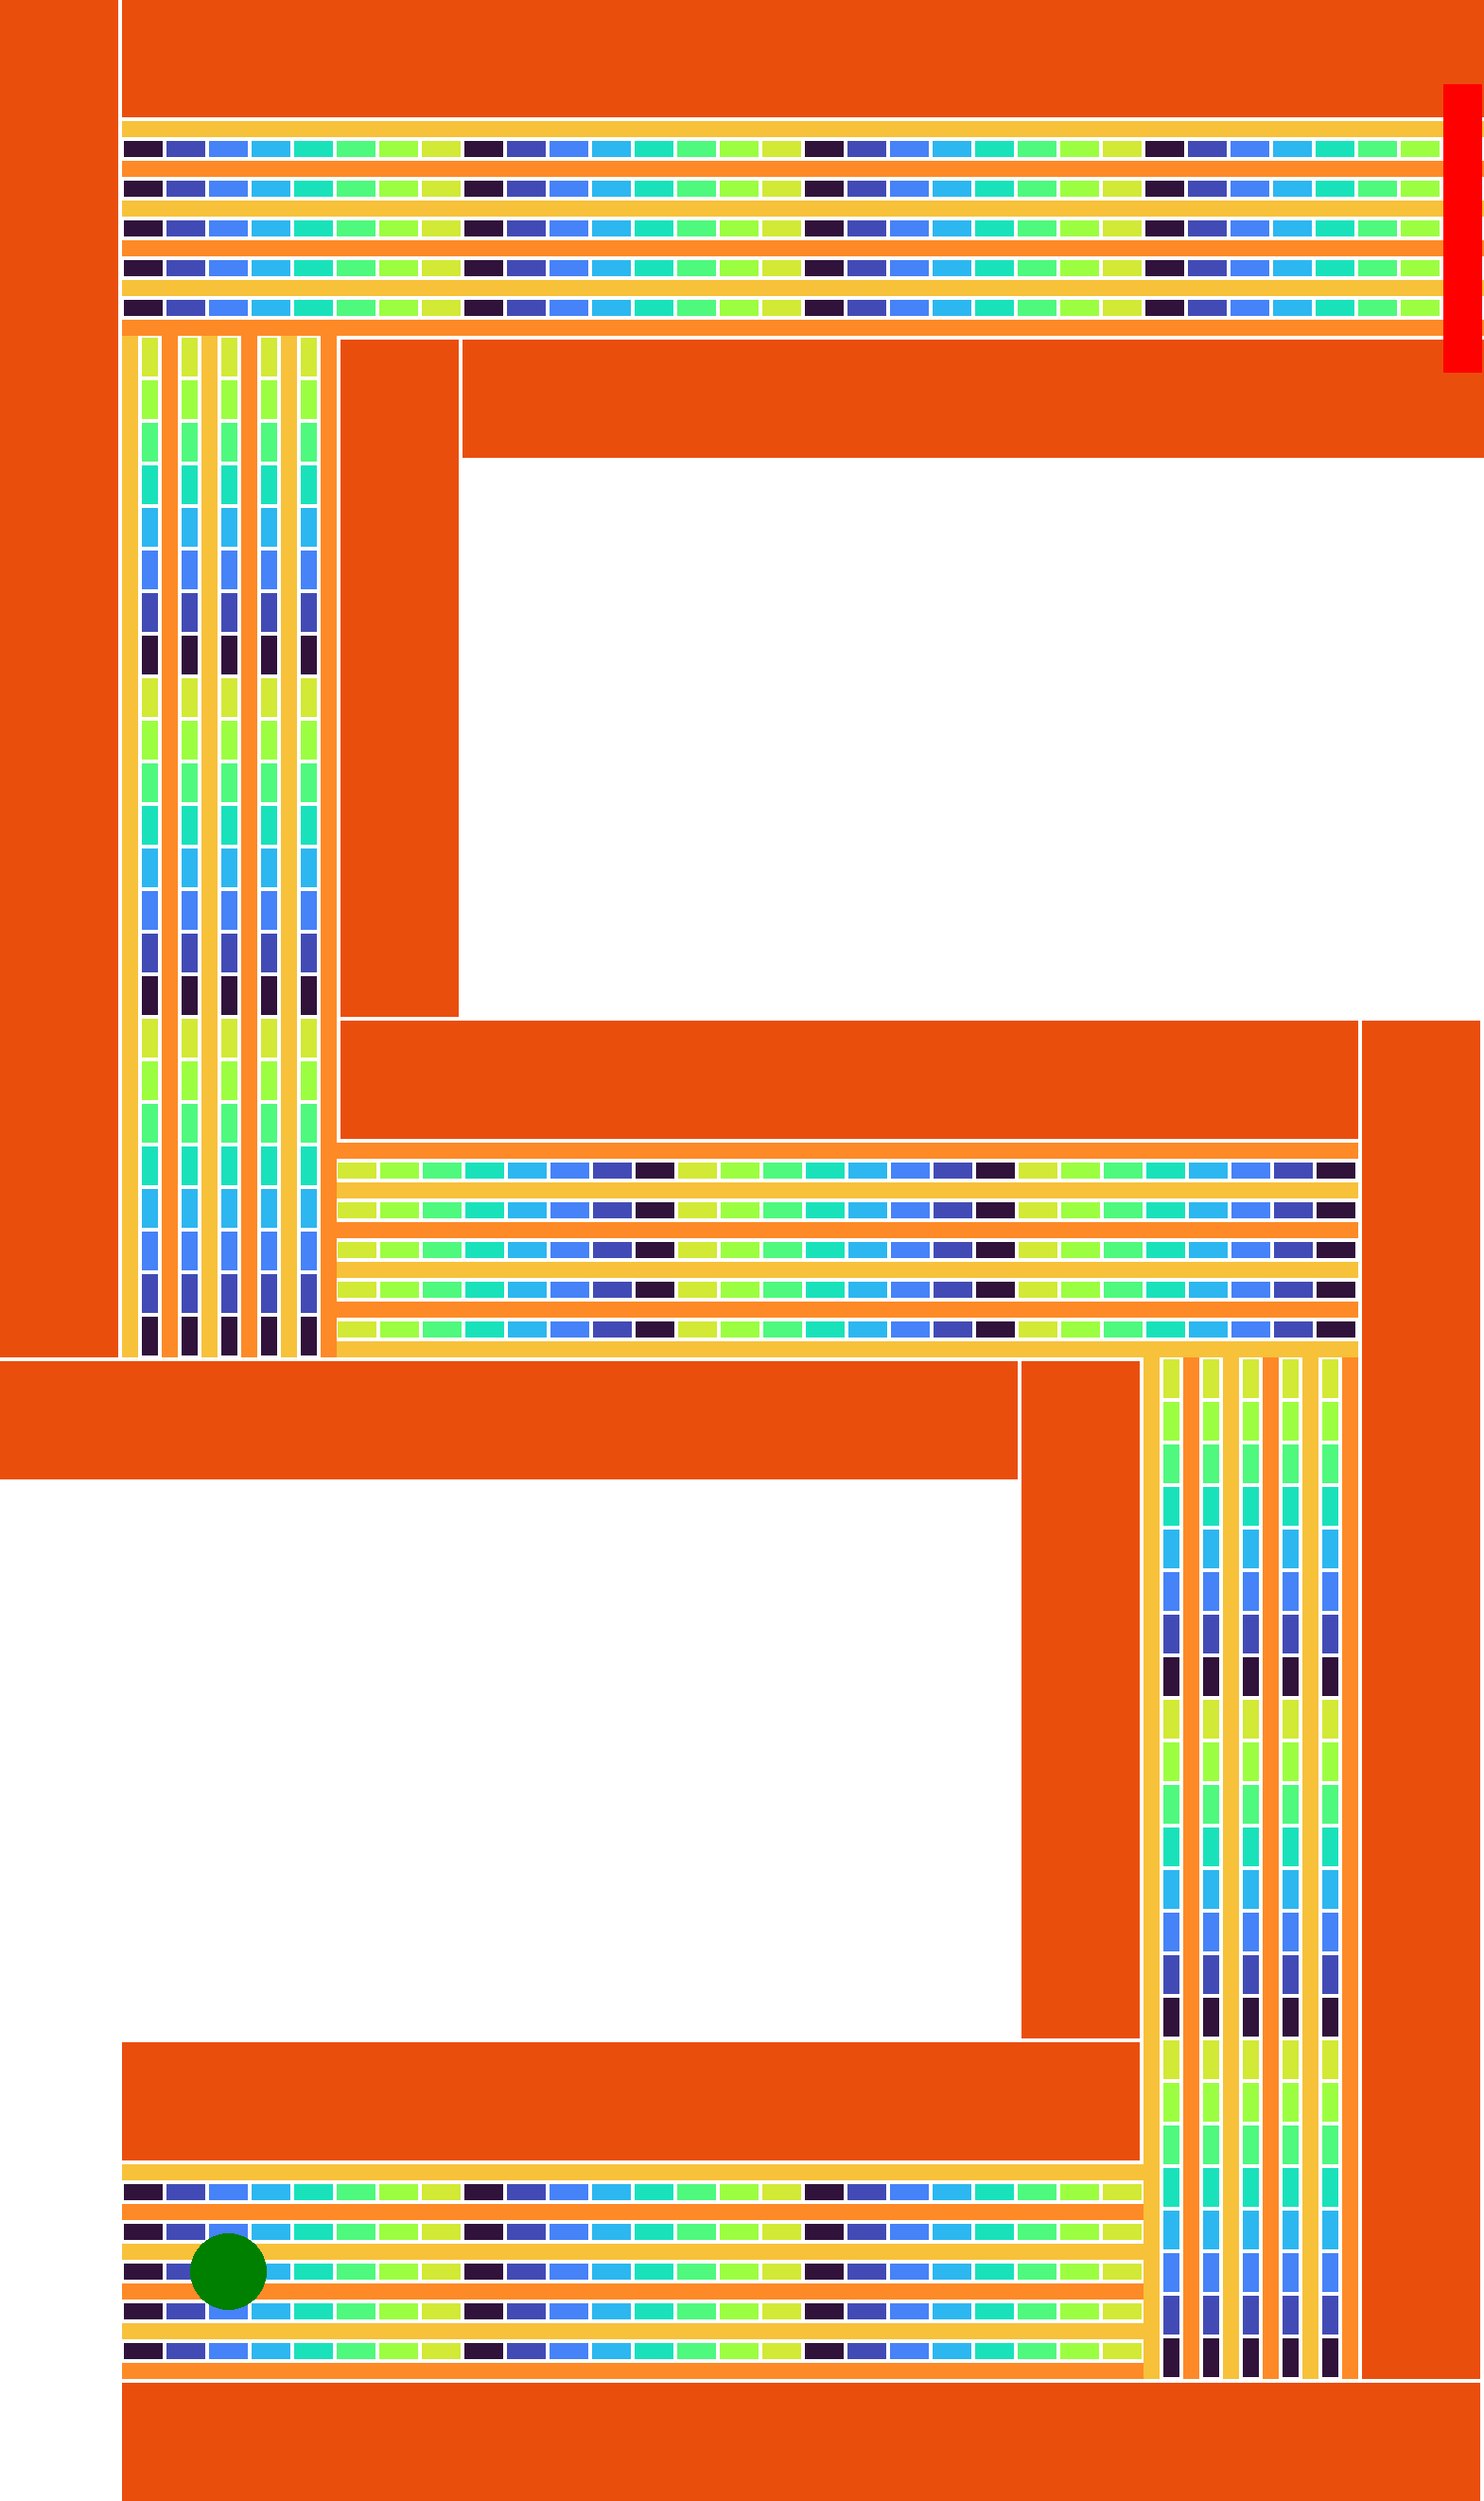

(6.1341, 6.1468, 1.5875)
[38.77, 57.15, 39.79, 64.87]


In [24]:
start, stop = start_and_stop(build_polys, stop_mer=-1, plotBool=True)
masses = [250, 500, 1000]
charges = list(np.full(len(masses), 1))
print(start)
print(stop)

In [25]:
stop_lua_arr = '{' + str(stop)[1:-1] + '}'
print(stop_lua_arr)

{38.77, 57.15, 39.79, 64.87}


In [26]:
# the start will go in the fly string, but the stop should be added to the params file
paramDict['splat_line'] = [stop_lua_arr, '    ----- rectangle box defining a fly finish line']
writeParamFile(paramDict, "Extrude_SLIM_Parameters.lua") 


Extrude_SLIM_Parameters.lua written to file 



In [27]:
print(start)

(6.1341, 6.1468, 1.5875)


In [28]:
# define fly2 string:
def flystring(masses, charges, start_pos, ions_per=30):
    
    fly_string = 'particles { coordinates = 0, '
    print(fly_string)
    for n, (m, c) in enumerate(zip(masses, charges)):
        entry = 'standard_beam {n = %i, '%ions_per + 'tob =0, mass = %i, '%m + 'charge = %i, '%c + 'cwf = 1, color = %i, '%n + 'direction = vector(1, 0, 0), position = vector(%s) },\n'%str(start)[1:-1]
        
        fly_string +=entry
        
    fly_string = fly_string[:-2]
    fly_string += ' }'
    return fly_string
        

In [29]:
fly_string = flystring(masses, charges, start)
print(fly_string)

particles { coordinates = 0, 
particles { coordinates = 0, standard_beam {n = 30, tob =0, mass = 250, charge = 1, cwf = 1, color = 0, direction = vector(1, 0, 0), position = vector(6.1341, 6.1468, 1.5875) },
standard_beam {n = 30, tob =0, mass = 500, charge = 1, cwf = 1, color = 1, direction = vector(1, 0, 0), position = vector(6.1341, 6.1468, 1.5875) },
standard_beam {n = 30, tob =0, mass = 1000, charge = 1, cwf = 1, color = 2, direction = vector(1, 0, 0), position = vector(6.1341, 6.1468, 1.5875) } }


In [30]:
saveGEMFile(fly_string, "%s.fly2"%design_name[1:-1]) # can re-use our save function to make this easy

ASY_pickins_test.fly2 written to disk


# Export the straight path:

In [31]:
# raise SystemExit("Stop here before overwriting user.gem or the param dicts, which aren't named exclusively...")
print('only continue if you would like to export the straight path and not anything created above')

only continue if you would like to export the straight path and not anything created above


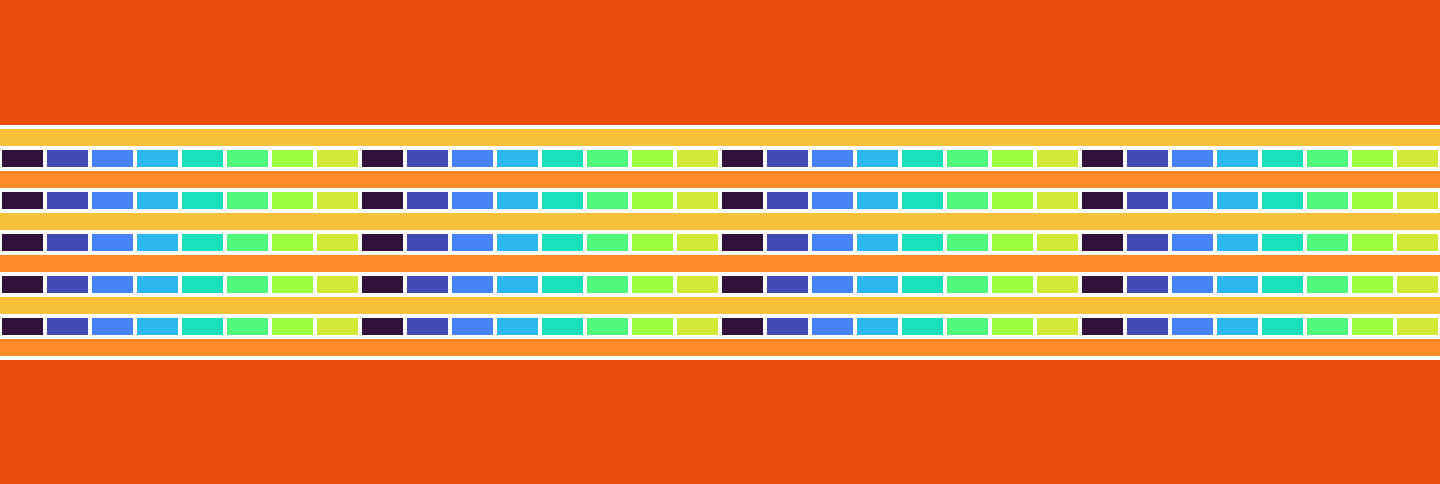

In [32]:
plotPolyList(tetramer_polys, tetramer_maxX, tetramer_maxY)

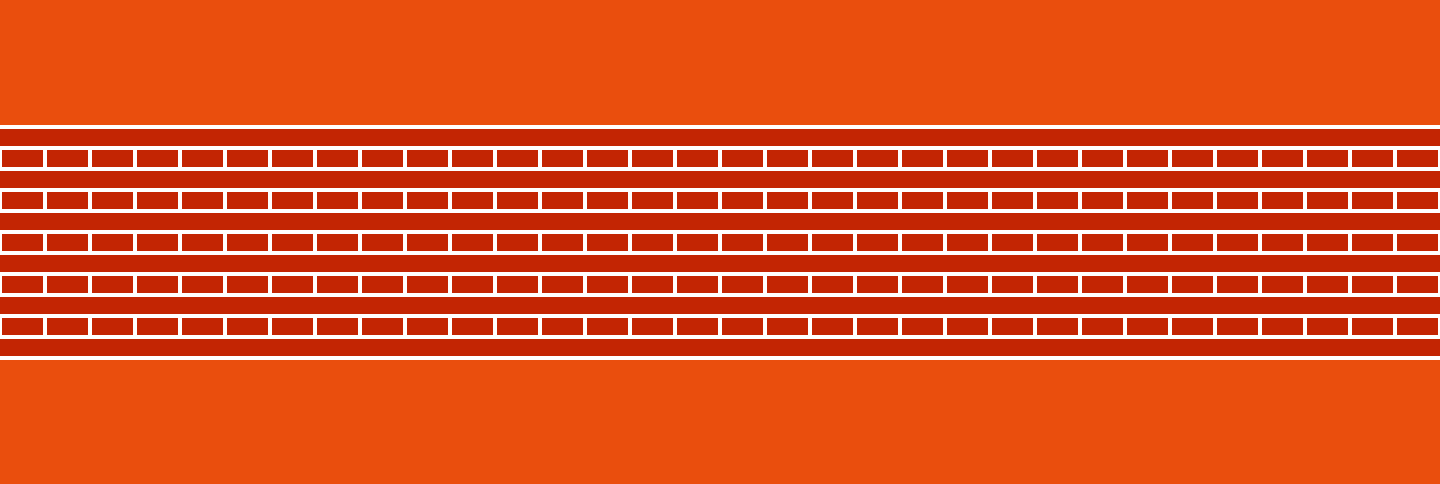

In [33]:
if symmetry == "'ASY'":
    im = plotPolyList(P_tetramer_polys, tetramer_maxX, tetramer_maxY)
    display(im)

In [34]:
# update our param dictionary to the new simulation length and width, and re-export
# this is critical for the SIMION space to match our image size

paramDict['totalLen'] = [tetramer_maxX*pixelScale, '--Total Length of the monomer (mm)']
paramDict['totalWidth'] = [tetramer_maxY*pixelScale, '--Total Width of the monomer (mm)']

# let's also add a name for our creation:
design_name = "'tetramer'"
if symmetry == "'ASY'":
    design_name = "'asy_tetramer'"
paramDict['design_title'] = [design_name, '--  Name for associated files']


print("%s"%design_name[1:-1])
writeParamFile(paramDict, "Extrude_SLIM_Parameters.lua") 
!cat "Extrude_SLIM_Parameters.lua"

gemStr = genGemStr(tetramer_polys)
if symmetry == "'ASY'":
    gemStr = genAsyGemStr(tetramer_polys, P_tetramer_polys)

# this is the electrode geometry file that will be read by our setup lua on init in SIMION
saveGEMFile(gemStr, 'user.gem')

asy_tetramer
Extrude_SLIM_Parameters.lua written to file 

Symmetry = 'ASY'    --Field Symmetry
wElectrode = 0.4064    --Width of the DC electrode (mm)
lElectrode = 1.016    --Length of the DC electrode (mm)
wRF = 0.4064    --Width of the RF (mm)
wGuard = 3.1496    --Width of the Guard (mm)
sp = 0.127    --Spacing between electrodes (mm)
numDC = 8    --Number of DC electrodes per TW Segment
numRowsDC = 5    --Number of rows of TWAVE segments
numRF = 6    --Number of RF Segments
numGuards = 2    --Number of Guard Segments
totalLen = 36.576    --Total Length of the monomer (mm)
totalWidth = 12.2936    --Total Width of the monomer (mm)
trackWidth = 5.9944    --Track Width (mm)
d = 1.5875    -- half distance between the layers/boards (mm)
elecDict = {["DC1"] = 1, ["DC2"] = 2, ["DC3"] = 3, ["DC4"] = 4, ["DC5"] = 5, ["DC6"] = 6, ["DC7"] = 7, ["DC8"] = 8, ["RF1"] = 9, ["RF2"] = 10, ["G"] = 11, ["P"] = 12}    -- elec keys : SIMION adj_elec dexes
design_title = 'asy_tetramer'    --  Name for as

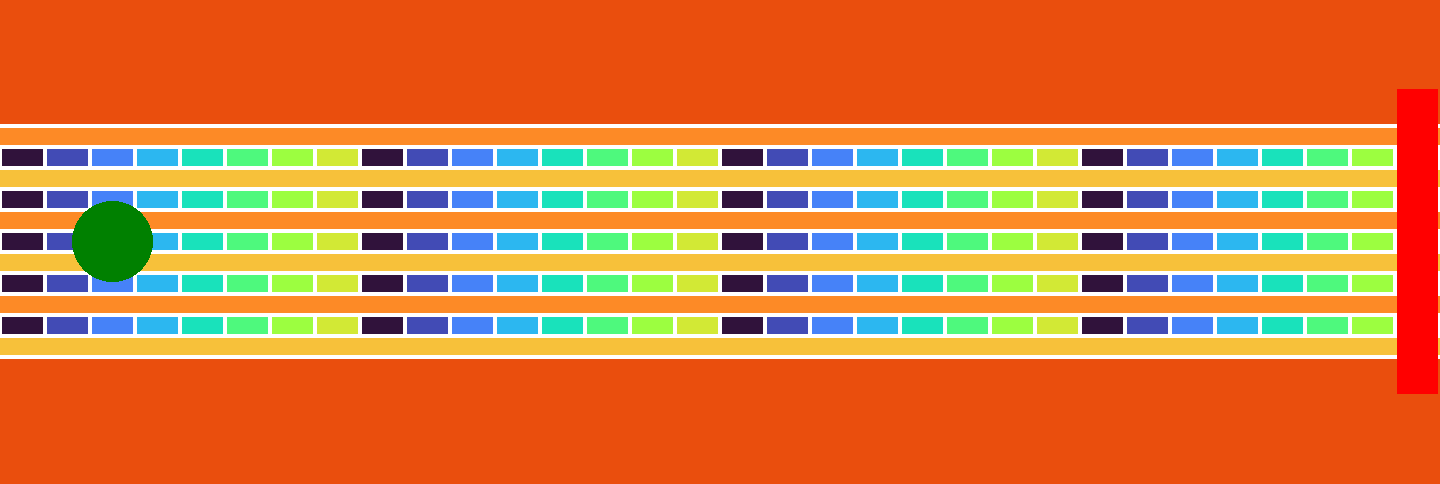

(2.8575, 6.1468, 1.5875)
[35.5, 2.29, 36.51, 10.01]
{35.5, 2.29, 36.51, 10.01}
Extrude_SLIM_Parameters.lua written to file 



In [35]:
start, stop = start_and_stop(tetramer_polys, stop_mer=-1, maxes = (tetramer_maxX, tetramer_maxY), plotBool=True)
masses = [322, 622, 922, 1222, 1522, 1822]
charges = list(np.full(len(masses), 1))
print(start)
print(stop)
                             
# the start will go in the fly string, but the stop should be added to the params file
stop_lua_arr = '{' + str(stop)[1:-1] + '}'
print(stop_lua_arr)
paramDict['splat_line'] = [stop_lua_arr, '    ----- rectangle box defining a fly finish line']
writeParamFile(paramDict, "Extrude_SLIM_Parameters.lua") 

In [36]:
fly_string = flystring(masses, charges, start)
saveGEMFile(fly_string, "%s.fly2"%design_name[1:-1]) # can re-use our save function to make this easy

particles { coordinates = 0, 
asy_tetramer.fly2 written to disk
